In [115]:
# !pip install pandas numpy matplotlib lifelines

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import os
from config import DATA_ROOT

# Make plots look a bit nicer
plt.style.use("default")

# %%
# 1. Read CSV
# --------------------------------------------------------------------
# Set CSV path here:

csv_path = os.path.join(DATA_ROOT, "original_data.csv")  #

df_raw = pd.read_csv(csv_path)

print("Raw shape:", df_raw.shape)
df_raw.head()


Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,04/2021,56,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,03/2025,35.3,48.2,12.9,9.2,3.7,9.2
1,2,3,"PGIMER, Chandigarh, India",SRS,08/2018,38,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,09/2024,17.9,74.4,56.5,55.8,0.7,55.8
2,3,1,Dokkyo Medical Universiry,SRS,02/2015,47,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,10/2015,4.8,8.0,3.2,2.8,0.4,2.8
3,4,7,Dokkyo Medical Universiry,SRS,02/2016,74,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,09/2017,9.5,19.6,10.2,9.0,1.1,9.0
4,5,13,Dokkyo Medical Universiry,SRS,06/2017,75,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,11/2020,25.7,40.9,15.2,14.8,0.4,14.8


In [116]:
csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()

Raw shape: (272, 120)


,b,#,Center,by,Date of first diagnosis (date of first surgery),Age at diagnosis,Sex (M/F),WHO 2021 Diagnosis \n(must be Glioblastoma),IDH status\n(must be Wildtype),MGMT (methyl/unmethyl/n.a.),...,Additional experimental treatment (yes: please specify/no).2,Bevacizumab (yes/no).1,Death (1: yes / 0: no),Date of death or last follow-up,PFS,OS,PRS,Survival from SRS,Time from progression to SRS,Time from SRS to 2nd progression
0,1,2,"PGIMER, Chandigarh, India",SRS,2021-04-05,56.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,0,2025-03-21,35.333333,48.200000,12.866667,9.200000,3.666667,9.200000
1,2,3,"PGIMER, Chandigarh, India",SRS,2018-08-10,38.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,0,2024-09-18,17.900000,74.366667,56.466667,55.766667,0.700000,55.766667
2,3,1,Dokkyo Medical Universiry,SRS,2015-02-23,47.0,F,Glioblastoma,WT,NaN,...,No progression,No progression,1,2015-10-22,4.800000,8.033333,3.233333,2.833333,0.400000,2.833333
3,4,7,Dokkyo Medical Universiry,SRS,2016-02-05,74.0,M,Glioblastoma,WT,NaN,...,No progression,No progression,1,2017-09-16,9.466667,19.633333,10.166667,9.033333,1.133333,9.033333
4,5,13,Dokkyo Medical Universiry,SRS,2017-06-28,75.0,M,Glioblastoma,WT,NaN,...,NaN,NaN,0,2020-11-06,25.733333,40.900000,15.166667,14.766667,0.400000,14.766667


In [117]:
# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"

# read in variables
df = df_raw[time_points + variables].copy()
for col in time_points:
    # check if there is any missing data
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
# add a new column to calculate survival time
df["Survival Time (days)"] = (pd.to_datetime(df["Date of death or last follow-up"]) - pd.to_datetime(df["Date of first recurrence per RANO (date of MRI)"])).dt.days

for col in variables:
    missing_count = df[col].isnull().sum()
    print(f"Missing values in '{col}': {missing_count}")
    # if missing, fill with median or mode
    if df[col].dtype in [np.float64, np.int64]:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# read a survival event column
df["Event Observed"] = df_raw["Death (1: yes / 0: no)"].astype(bool)
missing_count = df["Event Observed"].isnull().sum()
print(f"Missing values in 'Event Observed': {missing_count}")

# survival time prediction
df = df[df["Survival Time (days)"] >= 0]  # remove negative survival times
print("Processed shape:", df.shape)

# use survivaltree to predict survival


df.head()



Missing values in 'Date of first recurrence per RANO (date of MRI)': 0
Missing values in 'Date of death or last follow-up': 0
Missing values in 'Age at diagnosis': 0
Missing values in 'KPS before SRS or re-RT for Recurrence': 5
Missing values in 'Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)': 16
Missing values in 'SRS Dose (Gy)': 1
Missing values in 'Event Observed': 0
Processed shape: (272, 8)


/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_90732/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/0j/jhw_p03509n_339vhrhc5y1w2663j_/T/ipykernel_90732/3262446240.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

,Date of first recurrence per RANO (date of MRI),Date of death or last follow-up,Age at diagnosis,KPS before SRS or re-RT for Recurrence,Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis),SRS Dose (Gy),Survival Time (days),Event Observed
0,2024-02-29,2025-03-21,56.0,80.0,3.000,16.0,386,False
1,2020-01-29,2024-09-18,38.0,90.0,1.020,10.0,1694,False
2,2015-07-17,2015-10-22,47.0,80.0,4.626,20.0,97,True
3,2016-11-15,2017-09-16,74.0,80.0,1.509,20.0,305,True
4,2019-08-09,2020-11-06,75.0,90.0,2.414,20.0,455,False


In [118]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

csv_path = os.path.join(DATA_ROOT, "original_data.xlsx")  
df_raw = pd.read_excel(csv_path)
print("Raw shape:", df_raw.shape)
df_raw.head()
# ---- compute PRS time ----
df = df_raw.copy()

# Time points for survival analysis
time_points = ["Date of first recurrence per RANO (date of MRI)",
"Date of death or last follow-up"]

# Variables needed
variables = ["Age at diagnosis",
"KPS before SRS or re-RT for Recurrence",
"Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)",
"SRS Dose (Gy)",
] # "MGMT (methyl/unmethyl/n.a.)"
# create mapping from original column names to standardized names
col_mapping = {
    "Date of first recurrence per RANO (date of MRI)": "recurrence_date",
    "Date of death or last follow-up": "death_or_lastFU_date",
    "Death (1: yes / 0: no)": "event_death",
    "Age at diagnosis": "age_dx",
    "KPS before SRS or re-RT for Recurrence": "kps_pre",
    "Pre-SRS/RT contrast-enhancing tumor volume in cm3 (incl. necrosis)": "ce_volume_cm3",
    "SRS Dose (Gy)": "srs_dose_gy"
}

df = df.rename(columns=col_mapping)

Raw shape: (272, 120)


              0
90.0   0.942773
180.0  0.818740
365.0  0.474761
            121
90.0   0.940296
180.0  0.811463
365.0  0.459232


<Figure size 640x480 with 0 Axes>

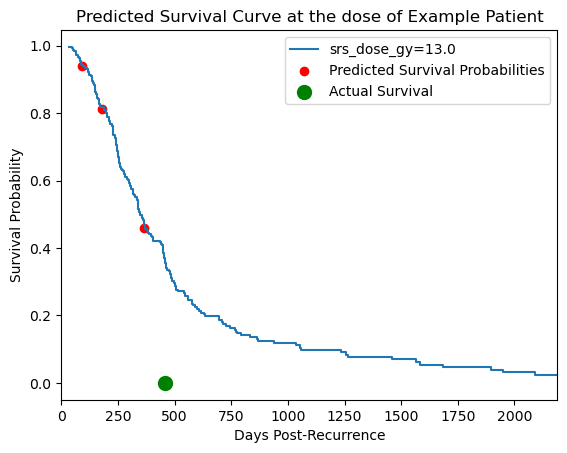

In [122]:
# =======================================================
# Example: Cox Proportional Hazards Model for Post-Recurrence Survival
# =======================================================
df["recurrence_date"] = pd.to_datetime(df["recurrence_date"])
df["death_or_lastFU_date"] = pd.to_datetime(df["death_or_lastFU_date"])
df["srs_dose_gy_square"] = df["srs_dose_gy"] ** 2
df["prs_days"] = (df["death_or_lastFU_date"] - df["recurrence_date"]).dt.days
if (df["prs_days"] <= 0).any():
    bad = df.loc[df["prs_days"] <= 0, ["recurrence_date", "death_or_lastFU_date", "prs_days"]]
    # remove these rows
    df = df[df["prs_days"] > 0]
    # raise ValueError(f"Found prs_days <= 0. Check dates:\n{bad.head()}")

# ---- feature engineering ----
df["log_volume"] = np.log1p(df["ce_volume_cm3"])

# Optional: consider age at recurrence instead (often more coherent than age_dx)
# if you have diagnosis_date:
# df["age_recur"] = df["age_dx"] + (df["recurrence_date"] - pd.to_datetime(df["diagnosis_date"])).dt.days / 365.25

model_df = df[["prs_days", "event_death", "age_dx", "kps_pre", "log_volume", "srs_dose_gy", "srs_dose_gy_square"]].dropna()

# ---- fit penalized Cox (L2) ----
cph = CoxPHFitter(penalizer=0.1)  # tune this with CV
cph.fit(model_df, duration_col="prs_days", event_col="event_death")

# print(cph.summary)
# ---- predict survival curve for a new patient ----
new_patient = pd.DataFrame([{
    "age_dx": 58,
    "kps_pre": 80,
    "log_volume": np.log1p(12.0),
    "srs_dose_gy": 18,
    "srs_dose_gy_square": 18**2
}])

surv_curve = cph.predict_survival_function(new_patient, times=[90, 180, 365])  # days
print(surv_curve)  # survival probabilities at 3, 6, 12 months

# =======================================================
Patient_Index = 114
# get a real data from the dataframe, make a prediction
example_patient = model_df.iloc[[Patient_Index]][["age_dx", "kps_pre", "log_volume", "srs_dose_gy", "srs_dose_gy_square"]]
example_surv_curve = cph.predict_survival_function(example_patient, times=[90, 180, 365])
print(example_surv_curve)
# plot the point that this patient falls on the survival curve
# plot the real survival curve for this patient
actual_survival_time = model_df.iloc[Patient_Index]["prs_days"]
actual_event = model_df.iloc[Patient_Index]["event_death"]      

import matplotlib.pyplot as plt
plt.figure()
cph.plot_partial_effects_on_outcome(covariates="srs_dose_gy",
                                    values=[example_patient["srs_dose_gy"].values[0]],
                                    plot_baseline=False)
plt.scatter([90, 180, 365], example_surv_curve.values.flatten(), color='red', label='Predicted Survival Probabilities')
ax = plt.gca()
ax.set_xlim(0, 365*6) # limit x-axis to 2 years
# ax.set_ylim(0.7, 1.0)
plt.title("Predicted Survival Curve at the dose of Example Patient")
plt.scatter([actual_survival_time], [0], color='green', s=100, label='Actual Survival')
plt.xlabel("Days Post-Recurrence")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

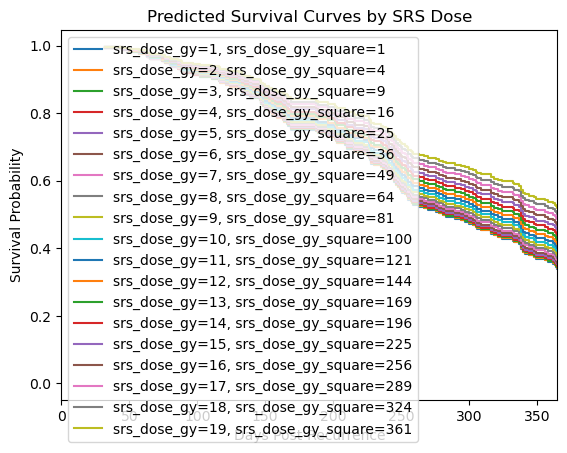

Dose: 0 Gy, Predicted 6-month Survival Probability: 0.7304
Dose: 2 Gy, Predicted 6-month Survival Probability: 0.7317
Dose: 4 Gy, Predicted 6-month Survival Probability: 0.7355
Dose: 6 Gy, Predicted 6-month Survival Probability: 0.7417
Dose: 8 Gy, Predicted 6-month Survival Probability: 0.7503
Dose: 10 Gy, Predicted 6-month Survival Probability: 0.7609
Dose: 12 Gy, Predicted 6-month Survival Probability: 0.7734
Dose: 14 Gy, Predicted 6-month Survival Probability: 0.7874
Dose: 16 Gy, Predicted 6-month Survival Probability: 0.8026
Dose: 18 Gy, Predicted 6-month Survival Probability: 0.8187
Dose: 20 Gy, Predicted 6-month Survival Probability: 0.8354
Dose: 22 Gy, Predicted 6-month Survival Probability: 0.8521
Dose: 24 Gy, Predicted 6-month Survival Probability: 0.8687
Dose: 26 Gy, Predicted 6-month Survival Probability: 0.8847
Dose: 28 Gy, Predicted 6-month Survival Probability: 0.9000
Dose: 30 Gy, Predicted 6-month Survival Probability: 0.9143
Dose: 32 Gy, Predicted 6-month Survival Proba

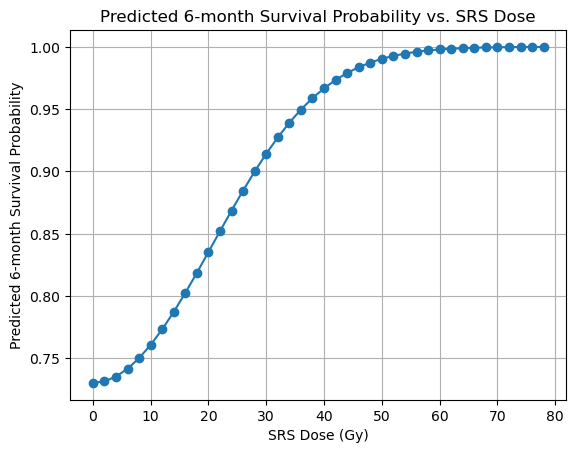

In [120]:
# =======================================================
# Optimal dose effect visualization
# =======================================================

# plot survival curve
import matplotlib.pyplot as plt
plt.figure()
cph.plot_partial_effects_on_outcome(covariates=["srs_dose_gy", "srs_dose_gy_square"],
                                    values=np.array([list(range(1,20)), [x**2 for x in range(1,20)]]).T,
                                    plot_baseline=False)
plt.title("Predicted Survival Curves by SRS Dose")
ax = plt.gca()
ax.set_xlim(0, 365) # limit x-axis to 1 year
# ax.set_ylim(0.7, 1.0)
plt.xlabel("Days Post-Recurrence")
plt.ylabel("Survival Probability")
plt.show()  



# probabilities at day 180 with different doses
doses = range(0, 80, 2)  # 0 to 35 Gy
prob_list = []
for dose in doses:
    patient = pd.DataFrame([{
        "age_dx": 58,
        "kps_pre": 80,
        "log_volume": np.log1p(12.0),
        "srs_dose_gy": dose,
        "srs_dose_gy_square": dose**2
    }])
    surv_curve = cph.predict_survival_function(patient, times=[180])
    print(f"Dose: {dose} Gy, Predicted 6-month Survival Probability: {surv_curve.values.flatten()[0]:.4f}")
    prob_list.append(surv_curve.values.flatten()[0])
# plot dose vs. 6-month survival probability
plt.figure()
plt.plot(doses, prob_list, marker='o')
plt.title("Predicted 6-month Survival Probability vs. SRS Dose")
plt.xlabel("SRS Dose (Gy)")     
plt.ylabel("Predicted 6-month Survival Probability")
plt.grid()
plt.show()